In [1]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from MMD import mmd_rbf, mmd_linear, mmd_poly
from tsl.datasets import AirQuality, MetrLA, PemsBay
from GRGN.Engines.Generator import Generator
from GRGN.GRGNModel import GRGNModel
from GRGN.Loss.LogLikelihood import LogLikelihood
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
import matplotlib.pyplot as plt
import torch


In [2]:
model_params = {
        'hidden_size': 128,
        'embedding_size': 16,
        'n_layers': 1,
        'kernel_size': 2,
        'decoder_order': 1,
        'layer_norm': True,
        'dropout': 0.05,
}
optim_params = {'lr': 0.00001, 'weight_decay': 0.01}

optim = 'RMSprop' # SGD or Adam

In [3]:
dataset = PemsBay()

adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe()[-10000:],
                                    covariates=None,
                                    connectivity=adj,
                                    window=1,
                                    stride=1)
scalers = {'target': StandardScaler(axis=(0, 1))}

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=32)
dm.setup(stage='test')

# if cfg.get('in_sample', False):
dm.trainset = list(range(len(torch_dataset)))

In [4]:
model_cls = GRGNModel

model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                    input_size=torch_dataset.n_nodes)


model_cls.filter_model_args_(model_kwargs)
model_kwargs.update(model_params)

loss_fn = LogLikelihood(both=True)

log_metrics = {
    '1stLL': LogLikelihood(False),
    '2ndLL': LogLikelihood(),
    '12LL': LogLikelihood(both=True),
}

scheduler_class = getattr(torch.optim.lr_scheduler, 'CosineAnnealingLR')
scheduler_kwargs = {'eta_min': 0.0001, 'T_max': 300}

# setup generator
generator = Generator(model_class=model_cls,
                    model_kwargs=model_kwargs,
                    optim_class=getattr(torch.optim, optim),
                    optim_kwargs=optim_params,
                    loss_fn=loss_fn,
                    metrics=log_metrics,
                    scheduler_class=scheduler_class,
                    scheduler_kwargs=scheduler_kwargs,
                    scale_target=True)

generator.load_model('/Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=04-val_loss=-0.0885.ckpt')


In [5]:

exp_logger = TensorBoardLogger(save_dir=f'logs/generation/grgn1/',
                                    name='tensorboard')
early_stop_callback = EarlyStopping(monitor='val_loss',
                                        patience=50,
                                        mode='min')

checkpoint_callback = ModelCheckpoint(
    dirpath='logs/generation/grgn1/',
    filename='best-model-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)

trainer = Trainer(
    max_epochs=500,
    default_root_dir='logs/generation/grgn1/',
    logger=exp_logger,
    accelerator='cpu',
    devices=1,
    gradient_clip_val=5,
    callbacks=[early_stop_callback, checkpoint_callback])

trainer.ckpt_path= '/Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=04-val_loss=-0.0885.ckpt'

generator.freeze()
# trainer.test(generator, datamodule=dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [6]:
output = trainer.predict(generator, dataloaders=dm.test_dataloader())
output = generator.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
res = dict(test_mae=loss_fn.loss_function(torch.tensor(y_hat), y_true))
res

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Restoring states from the checkpoint path at /Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=04-val_loss=-0.0885.ckpt
Loaded model weights from the checkpoint at /Users/paulmagos/Documents/TSGen/logs/generation/grgn1/best-model-epoch=04-val_loss=-0.0885.ckpt
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 w

Predicting DataLoader 0:   0%|          | 0/999 [00:00<?, ?it/s]

Only args ['edge_index', 'x', 'edge_weight'] are forwarded to the model (GRGNModel). 


Predicting DataLoader 0: 100%|██████████| 999/999 [00:43<00:00, 22.79it/s]


{'test_mae': tensor([[-2.4180]])}

In [7]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)

In [8]:
out = y_hat[..., :(1 + 2) * 32]
out = scalers['target'].transform(out)
out = torch.tensor(out)    
D = out.shape[-1] // 32 - 2

means = out[..., :32*D]
stds  = out[..., 32*D:32 * (D+1)]
weights = out[..., 32*(D+1):]

pred = weights * torch.normal(means, stds)
pred = torch.sum(pred, dim=-1)
pred = scalers['target'].inverse_transform(pred)

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_43084/3700738302.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out)


In [9]:
X = y_true.reshape(y_true.shape[0], -1)
Y = pred.reshape(y_true.shape[0], -1)

In [10]:
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.0020020019728690386

In [11]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

/Users/paulmagos/Documents/TSGen/MMD.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  return delta.dot(delta.T)


tensor(13467.3154)

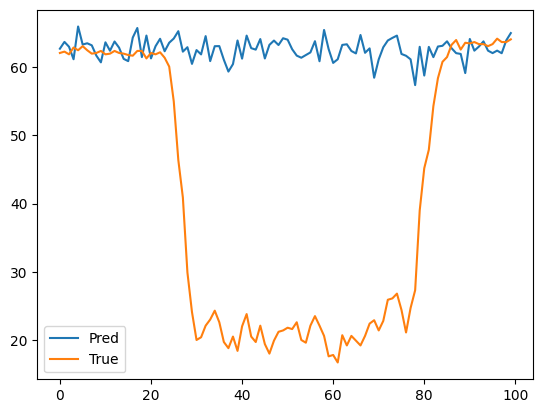

In [12]:
plt.plot(Y[:100, 1], label='Pred')
plt.plot(X[:100, 1], label='True')
plt.legend()

In [18]:
y_true.shape

input = y_true[-100:-99]
input = scalers['target'].transform(input)
input.shape

torch.Size([1, 1, 325, 1])

In [19]:
generation, out = generator.generate(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), None, 99, first_part=True)

In [20]:
generation = torch.cat(generation)
true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
generation = generation.reshape(generation.shape[0], generation.shape[-2])
generation = scalers['target'].inverse_transform(generation)[0]
generation.shape

torch.Size([99, 325])

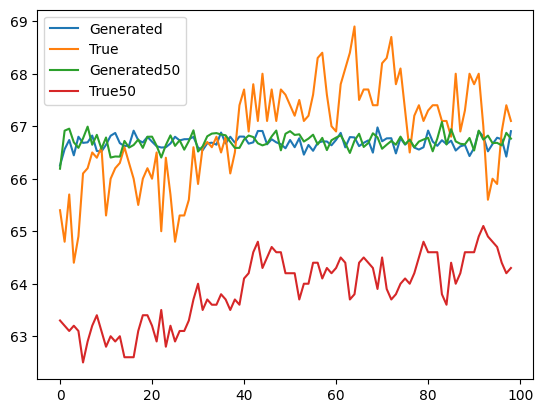

In [21]:
plt.plot(generation[:, 30], label='Generated')
plt.plot(true[-99:, 30], label='True')

plt.plot(generation[:, 50], label='Generated50')
plt.plot(true[-99:, 50], label='True50')
plt.legend()

In [22]:
out = torch.cat(out)

out = out[..., :(1 + 2) * 32]
out = torch.tensor(out)    
D = out.shape[-1] // 32 - 2

print(out.shape, D)

means = out[..., :32*D]
stds  = out[..., 32*D:32 * (D+1)]
weights = out[..., 32*(D+1):]

pred = weights * torch.normal(means, stds)
pred = torch.sum(pred, dim=-1)
pred = scalers['target'].inverse_transform(pred)

torch.Size([99, 1, 325, 96]) 1


/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_43084/3331475320.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out)


In [23]:
pred = pred.reshape(pred.shape[0], pred.shape[-1])

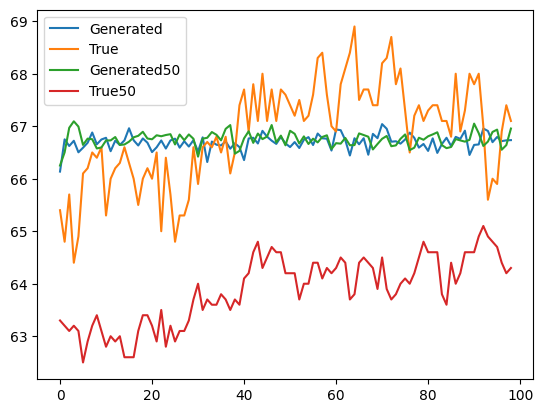

In [24]:
plt.plot(pred[:, 30], label='Generated')
plt.plot(true[-99:, 30], label='True')

plt.plot(pred[:, 50], label='Generated50')
plt.plot(true[-99:, 50], label='True50')
plt.legend()

In [25]:
X = true
Y = generation
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.011102011427283287

In [26]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))


tensor(15437.5352)

In [27]:
y_true.shape

input = y_true[-100:]
input = scalers['target'].transform(input)
input.shape

torch.Size([100, 1, 325, 1])

In [28]:
prediction, out = generator.predict(input, torch.tensor(adj[0]), torch.Tensor(adj[1]))

In [29]:
prediction.shape

torch.Size([100, 1, 325])

In [30]:
# prediction = torch.cat(prediction)
prediction = prediction.reshape(prediction.shape[0], prediction.shape[-1])
prediction = scalers['target'].inverse_transform(prediction)[0]
prediction.shape

torch.Size([100, 325])

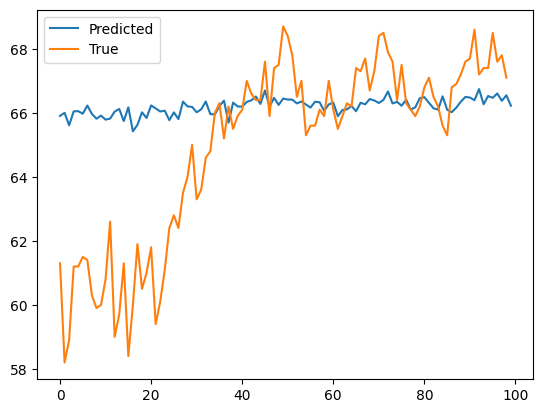

In [31]:
plt.plot(prediction[:, 10], label='Predicted')
plt.plot(true[-99:, 10], label='True')
plt.legend()

In [32]:
X = true
Y = generation
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.011102011427283287

In [33]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))


tensor(15437.5352)